In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [2]:
# import negative emotion labeled ads
df = pd.read_csv('./data/negative_emotion_dataset.csv').drop(columns= ['Unnamed: 0'])
df

,ad,neg_emo
0,x match your matching gift now will support hu...,1
1,volcán de fuego relief project we are sharing ...,1
2,stand with sharice gtgt republicans to drop a ...,1
3,a dedicated leader with proven experience and ...,1
4,years of obstruction corruption and failed le...,1
...,...,...
23995,oregon the top us producer of christmas trees ...,0
23996,the real winners when we invest in natgas and ...,0
23997,congresswoman mimi walters helped add almost ...,0
23998,trump brags that the economy is booming but s...,0


In [5]:
norm_train, norm_test,  y_train, y_test = train_test_split(df['ad'], df['neg_emo'], test_size =0.2, random_state=42)

In [9]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('ishikawa', 47105), ('<PAD>', 0), 1)

In [10]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [11]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((19199, 1000), (4800, 1000))

In [12]:
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
            Attention Layer sourced from : https://github.com/lzfelix/keras_attention/blob/master/attention/layers.py

            Implementation based in the work of Yang et al. "Hierarchical Attention Networks for Document Classification". 
            This implementation also allows changing the common tanh activation function used on the attention layer, as Chen
            et al. "A Thorough Examination of the CNN/Daily Mail Reading Comprehension Task"
            point that removing this component can be beneficial to the model. Supports
            masking.
    
            The mathematical formulation of the model is as follows:
              ```
              u = f(W * h + b),
              a_i = softmax(u_i^T * u_s),
              v_i = \sigma_i a_i * h_i.
              ```
    
            # Arguments
                  activation: The activation function f used by the layer (see
                      [activations](../activations.md)). By default tanh is used, another common
                      option is "linear".
                  use_bias: Boolean, whether the layer uses a bias vector.
                  initializer: Initializer for the `kernel` and `context` matrices
                      (see [initializers](../initializers.md)).
                  return_attention: If True, instead of returning the sequence descriptor, this
                      layer will return the computed attention coefficients for each of the
                      sequence timesteps. See Output section for details.
                  W_regularizer: Regularizer function applied to the `kernel` weights matrix
                      (see [regularizer](../regularizers.md)).
                  u_regularizer: Regularizer function applied to the `context` weights matrix
                      (see [regularizer](../regularizers.md)).
                  b_regularizer: Regularizer function applied to the bias vector
                      (see [regularizer](../regularizers.md)).
                  W_constraint: Constraint function applied to the `kernel` weights matrix
                      (see [constraints](../constraints.md)).
                  u_constraint: Constraint function applied to the `contextl` weights matrix
                      (see [constraints](../constraints.md)).
                  b_constraint: Constraint function applied to the bias vector
                      (see [constraints](../constraints.md)).
          # Input shape
                  nD tensor with shape: `(batch_size, ..., timesteps, input_dim)`.
                  The most common situation would be a 3D input with shape
                  `(batch_size, timesteps, input_dim)`.
          # Outuput shape
                  The sequence descriptor with shape `(batch_size, ..., timestamps)`. If
                  `return_attention` is True, this layer will return the `alpha_i` weights
                  for each timestep, and consequently its output shape will be different, namely:
                  `(batch_size, ..., timesteps)`. 
        """
        
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape= (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
def create_model(vocab_size, embedding_dim, max_sequence_length, gru_dim,dropout = 0.2):
  '''
    Create a Bidirectional GRU used for binary text classification task
    Arguments : 
      vocab_size: vocabulary size 
      embedding_dim: embedding dimensions for the document vector representation 
      max_sequence_length: input sequence length for each document 
      gru_dim: number of neurones in the GRU layers
      dropout : dropout rate used for Dropout regularization layers to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - Input layer to instantiate a tensor using the input preprocessed data
            - Embedding layer to represent each document with a context vector
            - Biderectional GRU (takes into consideration bidrectional context)
            - A custom attention layer that takes **all** of the output of the GRU ( not the last hidden state only)
            - Dense layer 
            - Dropout layer to minimize overfitting
            - A Dense layer 
            - Dropout 
            - An output layer to get the label of the class 
  '''
  model = Sequential([
      layers.Input(shape=(max_sequence_length,)),
      layers.Embedding(vocab_size, embedding_dim, trainable=True),
      layers.Bidirectional(layers.GRU(gru_dim, return_sequences=True)),
      AttentionLayer(max_sequence_length),
      layers.Dense(gru_dim*2, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(gru_dim, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [14]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units
VOCAB_SIZE = len(t.word_index)

# Create the model
model = create_model(vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, max_sequence_length = MAX_SEQUENCE_LENGTH, gru_dim = GRU_DIM)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         6029568   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 256)        198144    
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 256)              1256      
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [15]:
# model training 
batch_size = 32
model.fit(X_train, y_train, epochs= 5, batch_size=batch_size, 
          shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
480/480 [==============================] - 53s 85ms/step - loss: 0.3779 - accuracy: 0.7993 - val_loss: 0.1020 - val_accuracy: 0.9682
Epoch 2/5
480/480 [==============================] - 40s 84ms/step - loss: 0.0634 - accuracy: 0.9820 - val_loss: 0.1066 - val_accuracy: 0.9667
Epoch 3/5
480/480 [==============================] - 41s 85ms/step - loss: 0.0226 - accuracy: 0.9941 - val_loss: 0.1071 - val_accuracy: 0.9729
Epoch 4/5
480/480 [==============================] - 40s 84ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.1280 - val_accuracy: 0.9807
Epoch 5/5
480/480 [==============================] - 40s 83ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1507 - val_accuracy: 0.9812


In [16]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

150/150 [==============================] - 4s 28ms/step - loss: 0.1258 - accuracy: 0.9844
Accuracy: 98.44%


In [17]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

150/150 [==============================] - 6s 33ms/step


[0, 0, 1, 0, 1, 1, 1, 0, 1, 1]

              precision    recall  f1-score   support

      no-NEG       0.98      0.99      0.98      2385
         NEG       0.99      0.98      0.98      2415

    accuracy                           0.98      4800
   macro avg       0.98      0.98      0.98      4800
weighted avg       0.98      0.98      0.98      4800

confusion matrix:
[[2361   24]
 [  51 2364]]



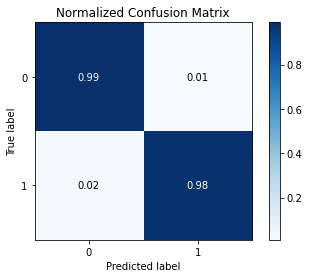

In [18]:
from sklearn import metrics

print(metrics.classification_report(y_test, predictions, target_names=['no-NEG', 'NEG']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [19]:
# save the test results 
save = pd.read_csv('./data/sample_negative_emotion.csv')

norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

scores = model.evaluate(padded_, save['neg_emo'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

4/4 [==============================] - 2s 69ms/step - loss: 3.0668 - accuracy: 0.8468
Accuracy: 84.68%


confusion matrix:
[[74  8]
 [11 31]]



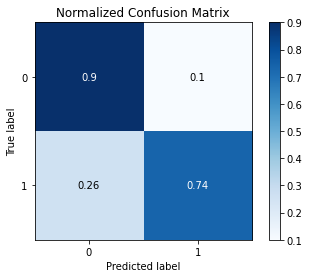

In [20]:
from sklearn import metrics
val_ = t.texts_to_sequences(norm_)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_, maxlen=MAX_SEQUENCE_LENGTH)
pred_ =  model.predict(padded_val)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(save['neg_emo'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['neg_emo'], save['predicted'], normalize=True)
plt.show()

In [21]:
print(metrics.classification_report(save['neg_emo'], save['predicted'], target_names=[ 'no-pos', 'pos']))

              precision    recall  f1-score   support

      no-pos       0.87      0.90      0.89        82
         pos       0.79      0.74      0.77        42

    accuracy                           0.85       124
   macro avg       0.83      0.82      0.83       124
weighted avg       0.84      0.85      0.85       124

